## 主要内容
- 线性回归方程实现
- 梯度下降效果
- 对比不同梯度下降策略
- 建模曲线分析
- 过拟合与欠拟合
- 正则化作用
- 提前停止策略

In [18]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings   # 主要是怕版本不同引起的错误

warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

### 回归方程：最小二乘法，直接得到显式解

#### step1：自行生成数据集

In [203]:
X = 2 * np.random.rand(100, 1)
# 要带上噪音
y = 4 + 3 * X + np.random.randn(100, 1)

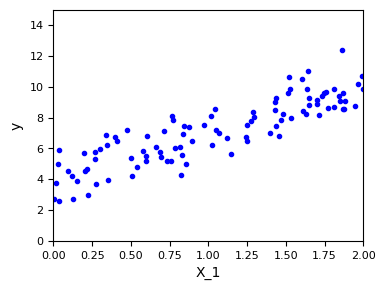

In [33]:
plt.figure(figsize=(4,3))
plt.scatter(X, y, c='blue', marker='.')
# plt.plot(X, y, 'b.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([0, 2, 0, 15])
plt.show()

#### step2：利用显式解公式，求得θ值
注意有一个偏置项，故要向X多添一列  
还要注意：矩阵的维数，是怎么相乘的——求θ的过程  
- np.dot(X_b.T, X_b)，得到是p*p的矩阵，p为特征数

In [207]:
X_b = np.c_[np.ones((X.shape[0], 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
# theta = np.dot(np.dot(np.linalg.inv(np.dot(X_b.T, X_b)), X_b.T), y)

print(theta_best)

[[4.1848496 ]
 [2.92493838]]


测试数据要和训练的数据处理步骤一样

In [204]:
X_test = np.array([[0], [2]])
X_test_b = np.c_[np.ones((2, 1)), X_test]

y_predict = X_test_b.dot(theta_best)
print(y_predict)

[[ 4.00299482]
 [10.01264144]]


画图用的是原始数据！即X_test

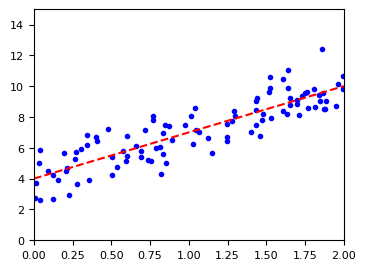

In [69]:
plt.figure(figsize=(4,3))
plt.plot(X_test, y_predict, 'r--')
plt.scatter(X, y, c='blue', marker='.')
plt.axis([0, 2, 0, 15])
plt.show()

### sklearn api 文档
 https://scikit-learn.org/stable/modules/classes.html  
 现用现查

In [71]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.coef_)
print(lin_reg.intercept_)


[[3.00482331]]
[4.00299482]


### 梯度下降
- 步长太小  
- 步长太大  
- 学习率尽可能小，随着迭代的进行应该越来越小
- 标准化：拿到数据之后基本都需要做一次标准化操作

#### method 1：批量(所有)梯度下降计算公式

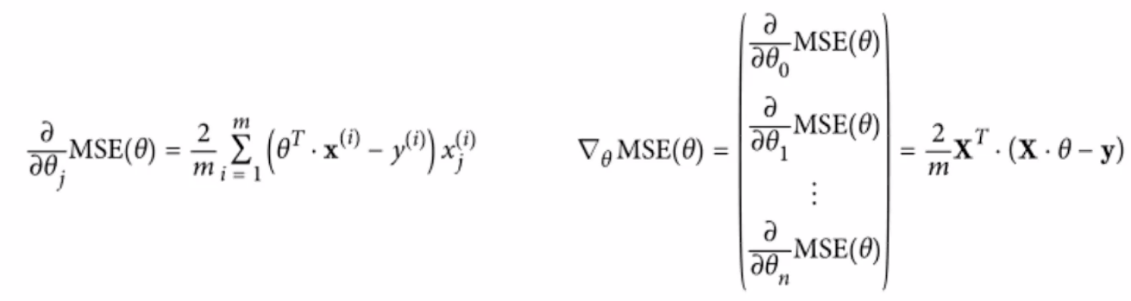

学习率、迭代次数、数量，**随机初始化**

In [80]:
learning_rate = 0.1
iter_num = 1000
m = X.shape[0]

theta = np.random.randn(2, 1)
for i in range(iter_num):
    gradient = (2 / m) * X_b.T.dot(X_b.dot(theta) - y)
    theta -= learning_rate * gradient
print(theta)

[[4.00299482]
 [3.00482331]]


In [81]:
y_predict = X_test_b.dot(theta)
print(y_predict)

[[ 4.00299482]
 [10.01264144]]


#### 对比不同学习率
**注意**：`theta = np.random.rand(2, 1)`的位置

In [215]:
theta_path_bgd = []
def plot_gradient_descent(theta, learning_rate, theta_path=None):
    theta = np.random.randn(2, 1)
    m = X.shape[0]
    plt.plot(X, y, 'b.')
    num_iteration = 1000
    for i in range(num_iteration):        
        y_predict = X_test_b.dot(theta)
        plt.plot(X_test, y_predict, 'r--')
        gradient = (2 / m) * X_b.T.dot(X_b.dot(theta) - y)
        theta -= learning_rate * gradient
        if theta_path is not None:  # 或者 if theta_path is not None:
            theta_path_bgd.append(theta.copy())
        plt.xlabel('X')
        plt.axis([0, 2, 0, 15])
        plt.title('learning rate = {}'.format(learning_rate)) 

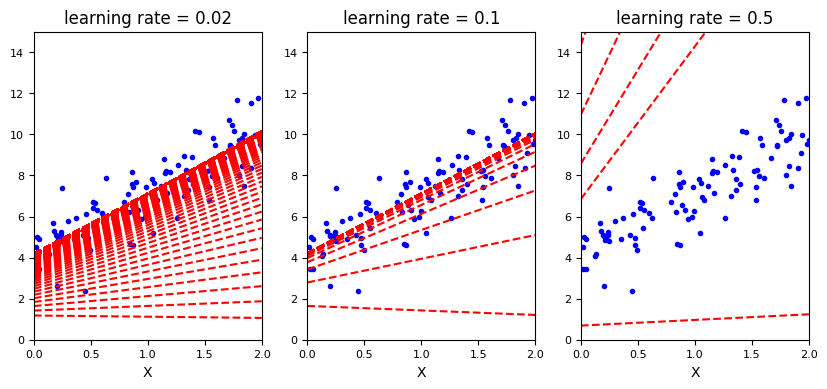

In [216]:
plt.figure(figsize=(10, 4))

plt.subplot(131)
plot_gradient_descent(theta, learning_rate=0.02)
plt.subplot(132)
plot_gradient_descent(theta, learning_rate=0.1, theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, learning_rate=0.5)

plt.show()

#### method 2：随机梯度下降
**衰减策略**  
**epoch**：将所有的样本迭代一次  
**.copy()**  
theta_path_sgd是一个列表，里面都是(2, 1)形状的NumPy数组

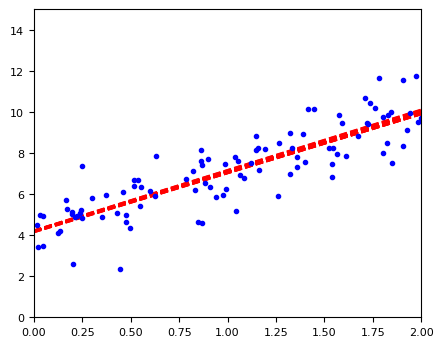

In [208]:
theta_path_sgd = []

m = X.shape[0]
n_epochs = 50 # 迭代次数

# 自行定义
t0 = 5
t1 = 50

# t可以表示迭代步数
def learning_rate_decay(t):
    return t0/(t1 + t)

plt.figure(figsize=(5, 4))

# 随机初始化
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        
        # 画一部分图
        if 40 < epoch <50 and i<2:
            y_predict = X_test_b.dot(theta)
            plt.plot(X_test, y_predict, 'r--')
        
        random_index = np.random.randint(m)
        xi = X_b[[random_index]]
        yi = y[random_index]
        gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
        learning_rate = learning_rate_decay(epoch * m + i)
        
        theta -= learning_rate * gradient
        theta_path_sgd.append(theta.copy())    
        # theta_path_sgd.append(theta)

plt.plot(X,y,'b.')
plt.axis([0,2,0,15])   
plt.show()

#### method 3：MiniBatch梯度下降
**衰减策略**  
**随机洗牌**

In [217]:
theta_path_mbgd = []
# np.random.seed(42) #可以使每次随机结果相同
n_epochs = 1000
minibatch = 16

theta = np.random.randn(2, 1)

t = 0 
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(minibatch):
        t += 1
        xi = X_b_shuffled[i: i+minibatch] # 因为已经是打乱的了
        yi = y_shuffled[i: i+minibatch]
        gradient = (2 / minibatch) * xi.T.dot(xi.dot(theta) - yi)
        learning_rate = learning_rate_decay(t)
        theta = theta - learning_rate * gradient
        theta_path_mbgd.append(theta.copy())

print(theta)

[[4.19039137]
 [2.93106883]]


### 3种策略对比实验

In [218]:
theta_path_bgd = np.array(theta_path_bgd).reshape(-1, 2)
theta_path_sgd = np.array(theta_path_sgd).reshape(-1, 2)
theta_path_mbgd = np.array(theta_path_mbgd).reshape(-1, 2)

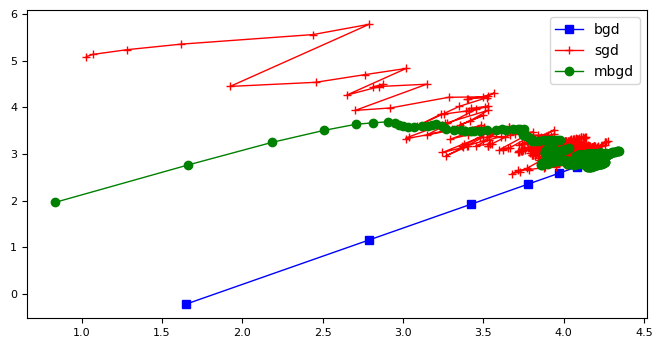

In [220]:
plt.figure(figsize=(8, 4))
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], 'b-s', linewidth=1, label='bgd')
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], 'r-+', linewidth=1, label='sgd')
plt.plot(theta_path_mbgd[:, 0], theta_path_mbgd[:, 1], 'g-o', linewidth=1, label='mbgd')
plt.legend(loc='upper right')
plt.show()

MiniBatch是最常用的方法，一般情况下batch数量应当越大越好

### 多项式回归

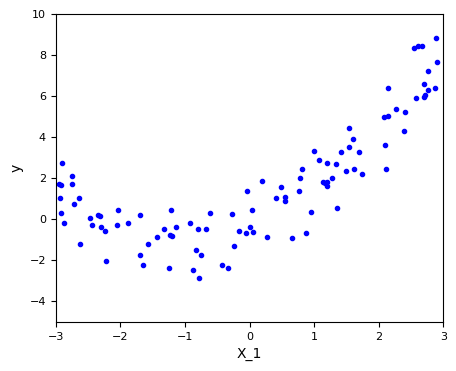

In [274]:
m = 100
X = 6 * np.random.rand(m, 1) -3
y = 0.5 * X**2 + X + np.random.randn(m, 1)

plt.figure(figsize=(5,4))
plt.plot(X, y, 'b.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([-3, 3, -5, 10])
plt.show()

#### PolynomialFeatures
#### step1:  
fit_transform：Fit to data, then transform it

In [275]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [276]:
print(X[0], X_poly[0])

[-2.04340768] [-2.04340768  4.17551494]


#### step2：对变换后的数据使用线性模型

In [277]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.coef_)
print(lin_reg.intercept_)

[[1.18630166 0.5589559 ]]
[-0.30578427]


#### step3：做出test集，画出图

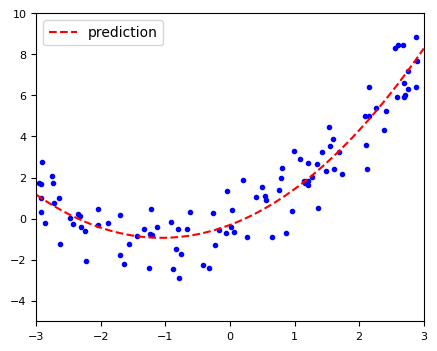

In [278]:
X_test = np.linspace(-3, 3, 100).reshape(-1, 1)
X_poly_test = poly_features.transform(X_test) # 不用再fit了
y_predict = lin_reg.predict(X_poly_test)

plt.figure(figsize=(5, 4))
plt.plot(X, y, 'b.')
plt.plot(X_test, y_predict, 'r--', label='prediction')
plt.legend()
plt.axis([-3, 3, -5, 10])
plt.show()

#### step3：对比实验（不同的degree）
过程：polynomial_features——standardize——model

**Pipeline**:  
`from sklearn.pipeline import Pipeline`：  
A sequence of data transformers with an optional final predictor  

**StandardScaler**:  
`from sklearn.preprocessing import StandardScaler`：  
Standardize features by removing the mean and scaling to unit variance

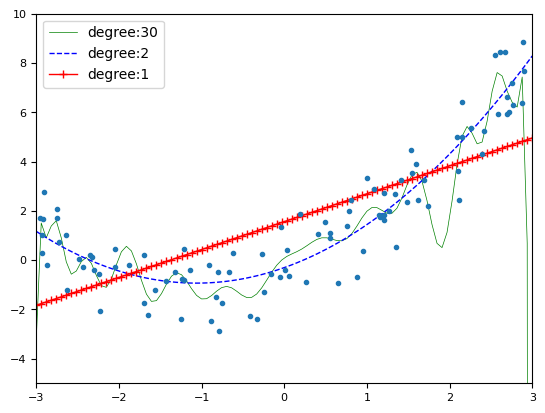

In [279]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# for i, (style, width, degree) in enumerate([('g-', 0.5, 30), ('b--', 1, 2), ('r-+', 1, 1)]):
#     plt.subplot(1, 3, i)

# fig, axes = plt.subplots(1, 3, figsize=(15, 3))
# for ax, (style, width, degree) in zip(axes, [('g-', 0.5, 30), ('b--', 1, 2), ('r-+', 1, 1)]):
#     ax.plot()
#     ax.plot()
#     ax.legend()

for style, width, degree in (('g-', 0.5, 30), ('b--', 1, 2), ('r-+', 1, 1)):
    
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    std = StandardScaler()
    lin_reg = LinearRegression()

    Poly_reg = Pipeline([
        ('poly_features', poly_features),
        ('StandardScaler', std),
        ('lin_reg', lin_reg),
    ])

    # 也可以直接写到Pipeline里面
    
    Poly_reg.fit(X, y)
    y_test_pred = Poly_reg.predict(X_test)

    plt.plot(X_test, y_test_pred, style, linewidth=width, label='degree:' + str(degree))
plt.plot(X, y, '.')
plt.axis([-3, 3, -5, 10])
plt.legend()
plt.show()

### 数据样本数量对结果的影响
**Metrics模块**：指标(度量)  
**mean_squared_error**  
**train_test_split**；`model_selection.train_test_split` 数据切分

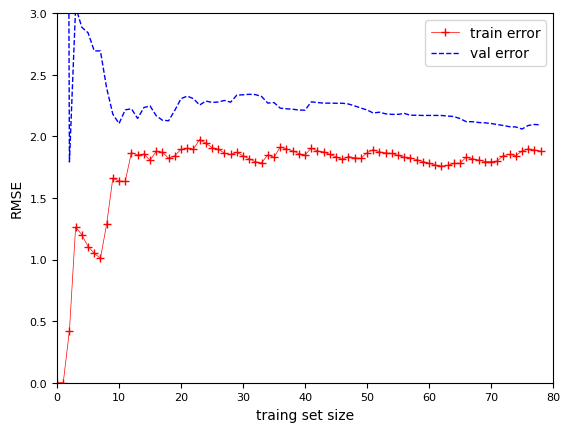

In [280]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # 每次随机都一样
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_predict = model.predict(X_train[:m])
        y_pred = model.predict(X_val) # 全部的训练集要一样
        
        train_errors.append(mean_squared_error(y_train[:m], y_predict))
        val_errors.append(mean_squared_error(y_val, y_pred))

    # mse的值会比较大，抖动也大，给开根
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=0.5, label='train error')
    plt.plot(np.sqrt(val_errors), 'b--', linewidth=1, label='val error')
    plt.xlabel('traing set size')
    plt.ylabel('RMSE')
    plt.legend()
        
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

数据量越少，训练集的效果会越好，但是实际车市效果很一般。实际做模型的时候需要参考测试集和验证集的效果

### 多项式回归的过拟合风险

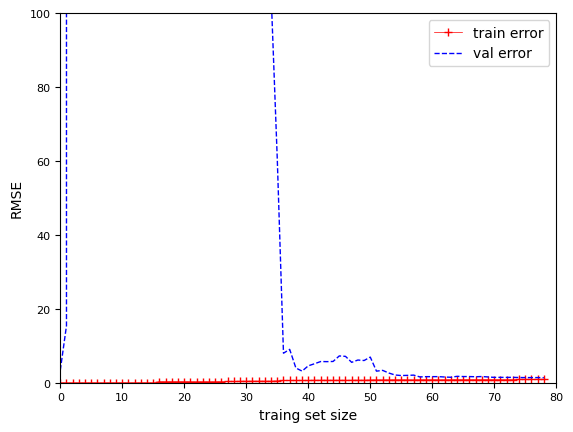

In [288]:
poly_std_reg = Pipeline([
    ('polynomial', PolynomialFeatures(degree=25, include_bias=False)),
    # ('standardscaler', StandardScaler()),
    ('lin_reg', LinearRegression()),
])

plot_learning_curve(poly_std_reg, X, y)
plt.axis([0, 80, 0, 100])
plt.show()

越复杂越过拟合

### 正则化
对权重参数进行惩罚，让权重参数尽可能平滑一些，有两种不同的方式来进行正则化惩罚


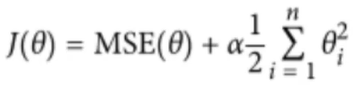  
**Ridge**：`sklearn.linear_model.Ridge`  
——Linear least squares with l2 regularization

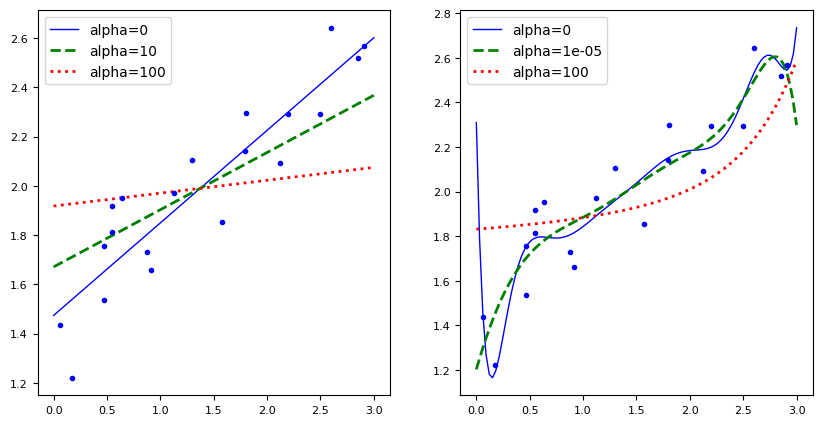

In [291]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 0.5 * X + np.random.rand(m, 1) / 1.5 + 1
X_test = np.linspace(0, 3, 100).reshape(-1, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs)
        if polynomial:            
            model = Pipeline([
                ('polynomial', PolynomialFeatures(degree=10, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lin_reg', model),
            ])
        model.fit(X, y)
        y_test_predict = model.predict(X_test)

        lw = 2 if alpha > 0 else 1
        plt.plot(X_test, y_test_predict, style, linewidth=lw, label='alpha={}'.format(alpha))
    plt.plot(X, y, 'b.', linewidth=2)
    plt.legend()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100))
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 100))
plt.show()

惩罚力度越大，即alpha越大，得到的决策方程越平稳

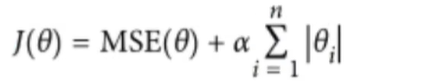  
**Lasso**:`sklearn.linear_model.Lasso`  
——Linear Model trained with L1 prior as regularizer (aka the Lasso)

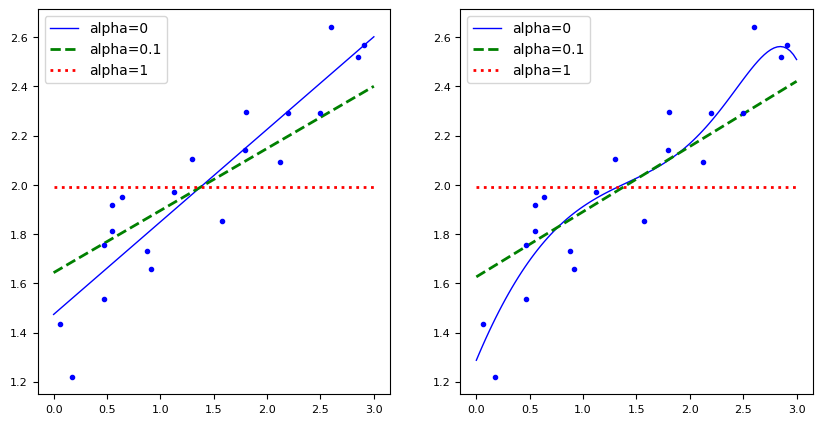

In [294]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1))
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-1, 1))
plt.show()